In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import copy
import os

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

from pytorch_tabnet.tab_model import TabNetRegressor


In [2]:
datasets = []


## Data Acquisition
##### Flat Acquisition using csv files

In [3]:
# Reading the csv files
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')
genome_scores = pd.read_csv('./data/genome-scores.csv')
genome_tags = pd.read_csv('./data/genome-tags.csv')


In [4]:
# Printing the first 5 rows of each dataframe
print('Movies:')
display(movies.head())
print('Ratings:')
display(ratings.head())
print('Tags:')
display(tags.head())
print('Genome Scores:')
display(genome_scores.head())
print('Genome Tags:')
display(genome_tags.head())


Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Tags:


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Genome Scores:


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


Genome Tags:


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### Data Wrangling

In [5]:
# ratings group by movieId with mean and count
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Dataset merge with movies and ratings, with missing rating films removed
df = pd.merge(movies, grouped_ratings, on='movieId')

display(df.head())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013


In [6]:
datasets.append({'transform': 'None', 'threshold': 'None', 'year': False, 'tags': True, 'genres': True, 'data': df, 'X_train': 'None', 'X_val': 'None', 'X_test': 'None', 'y_train': 'None', 'y_val': 'None', 'y_test': 'None', 'pca': False})


In [7]:
# Group by tagId and compute mean relevance
mean_relevance = genome_scores.groupby('tagId').mean()['relevance']

# Filter out tags with low mean relevance
threshold = 0.0
good_tags = mean_relevance.where(mean_relevance > threshold).dropna().index
genome_scores_2 = genome_scores[genome_scores['tagId'].isin(good_tags)]

# Merge movies with genome scores
genome_scores_2['tag'] = genome_scores_2['tagId'].map(genome_tags.set_index('tagId')['tag'].to_dict())
genome_table = genome_scores_2.pivot_table(index='movieId', columns='tag', values='relevance')

# Merge movies with genome table
df_test = pd.merge(df, genome_table, on='movieId')
print('Threshold: {}'.format(threshold))

datasets.append({'transform': 'None', 'threshold': threshold, 'year': False, 'tags': True, 'genres': True, 'data': df_test, 'X_train': 'None', 'X_val': 'None', 'X_test': 'None', 'y_train': 'None', 'y_val': 'None', 'y_test': 'None', 'pca': False})

# remove dataset with no tags
datasets = datasets[1:]

display(datasets[0]['data'].head())

Threshold: 0.0


,movieId,title,genres,mean_rating,rating_count,mean_timestamp,007,007 (series),18th century,1920s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,0.02875,0.02375,0.06250,0.07575,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,0.04125,0.04050,0.06275,0.08275,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,0.04675,0.05550,0.02925,0.08700,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,0.03425,0.03800,0.04050,0.03100,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,0.04300,0.05325,0.03800,0.04100,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


### Data Preparation (Data cleaning, Duplicates filtering, Data encoding)

##### Data Cleaning

In [8]:
for i, dataset in enumerate(datasets):
    df = dataset['data']

    print('\nFillna for dataset {}'.format(i+1))
    print('Number of rows: ', df.shape[0])
    df = df.fillna(0)
    print('Number of rows after dropping missing values: ', df.shape[0])

    datasets[i]['data'] = df



Fillna for dataset 1
Number of rows:  13816
Number of rows after dropping missing values:  13816


##### Data Encoding
Multicategorical One-Hot encoding for film genres

In [9]:
for i, dataset in enumerate(datasets):

    df = dataset['data']

    # one hot encoding for genres
    categories = set()
    for s in df['genres'].str.split('|').values:
        if s != ['(no genres listed)']:
            categories = categories.union(set(s))

    # add a column for each category
    for category in categories:
        df[category] = df['genres'].str.contains(category).astype(int)

    # delete genres column
    df = df.drop(columns=['genres'])

    datasets[i]['data'] = df

display(df.head())

,movieId,title,mean_rating,rating_count,mean_timestamp,007,007 (series),18th century,1920s,1930s,...,IMAX,Mystery,Adventure,Horror,Romance,Western,Musical,Film-Noir,Animation,Comedy
0,1,Toy Story (1995),3.893708,57309,1153152210,0.02875,0.02375,0.06250,0.07575,0.14075,...,0,0,1,0,0,0,0,0,1,1
1,2,Jumanji (1995),3.251527,24228,1122310117,0.04125,0.04050,0.06275,0.08275,0.09100,...,0,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),3.142028,11804,980602256,0.04675,0.05550,0.02925,0.08700,0.04750,...,0,0,0,0,1,0,0,0,0,1
3,4,Waiting to Exhale (1995),2.853547,2523,942460471,0.03425,0.03800,0.04050,0.03100,0.06500,...,0,0,0,0,1,0,0,0,0,1
4,5,Father of the Bride Part II (1995),3.058434,11714,1004723013,0.04300,0.05325,0.03800,0.04100,0.05400,...,0,0,0,0,0,0,0,0,0,1


##### Duplicates Filtering
The following results show that there are no duplicates in the dataset.

In [10]:
for i, dataset in enumerate(datasets):
    
    df = dataset['data']

    print('\nData filtering for dataset {}'.format(i+1))
    print('Number of rows: ', df.shape[0])
    df = df.drop_duplicates()
    print('Number of rows after dropping duplicated rows: ', df.shape[0])

    datasets[i]['data'] = df



Data filtering for dataset 1
Number of rows:  13816
Number of rows after dropping duplicated rows:  13816


## Data Visualization

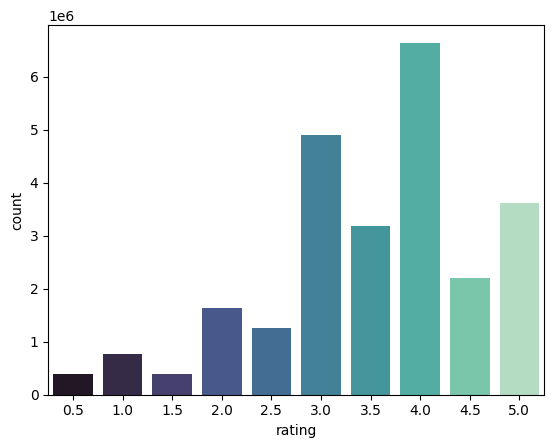

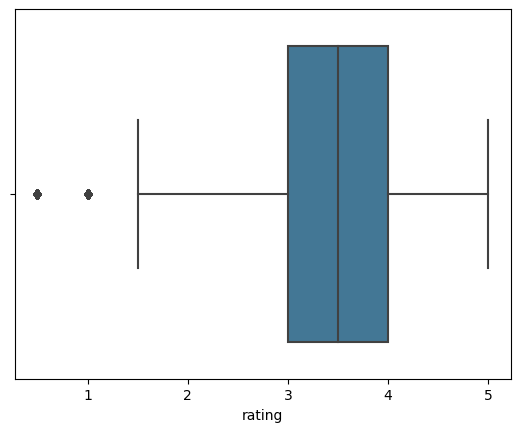

In [11]:
# rating distribution from ratings.csv
sns.countplot(x='rating', data=ratings, palette='mako')
plt.show()

sns.boxplot(x='rating', data=ratings, palette='mako')
plt.show()


Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. This is used for continuous attributes like rating mean.

It is done to show differences after data aggregation in calculating mean for each film.

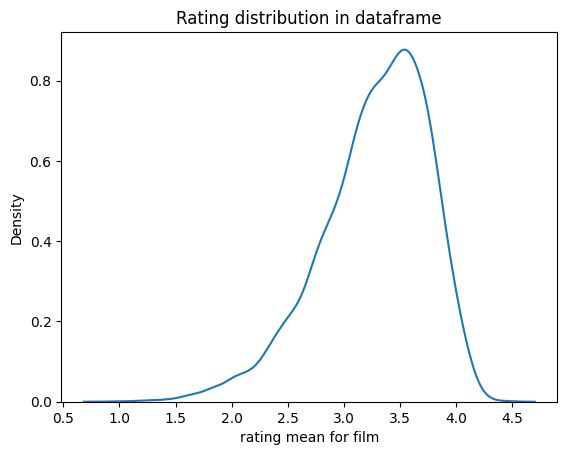

In [12]:
df = datasets[0]['data']

# rating distribution from df
sns.kdeplot(df['mean_rating'], palette='mako')
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()


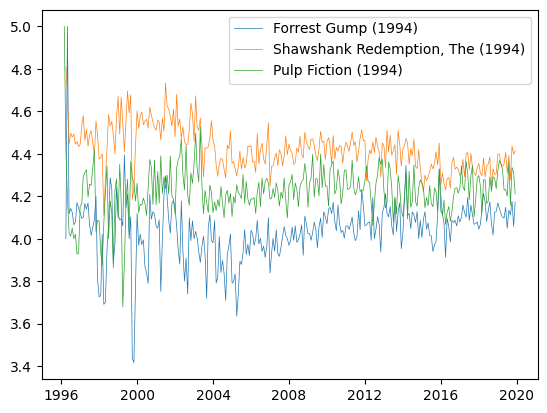

In [13]:
movies_to_show = 3

most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index

for i in range(movies_to_show):
    data = ratings.where(ratings['movieId'] == most_rated_movies[i]).dropna()
    data['date'] = pd.to_datetime(data['timestamp'], unit='s')
    
    # Computing the mean for each month
    data = data.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    movie_title = movies.where(movies['movieId'] == most_rated_movies[i]).dropna()['title'].values[0]
    data['title'] = movie_title
    
    # Visualization
    x = data.index
    y = data['rating']
    plt.plot(x, y, label=movie_title, linewidth=0.5)

plt.legend()
plt.show()

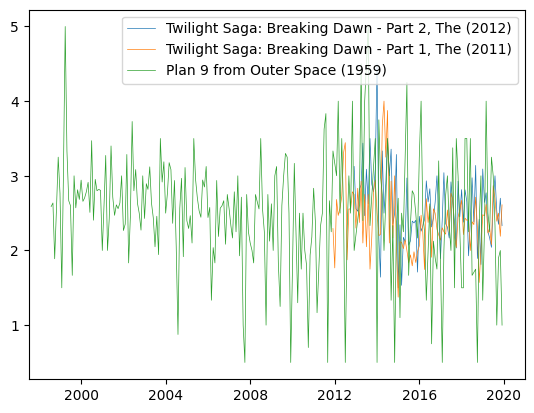

In [14]:
# Same as above cell but the 3 movies with the highest standard deviation
movies_to_show = 3

# Take movies with at least 1000 ratings
high_std_movies = ratings.where(
    ratings['movieId']
    .isin(ratings.groupby('movieId')
          .count()
          .where(ratings.groupby('movieId').count()['rating'] > 1000)
          .dropna().index)
    ).dropna()

high_std_movies = high_std_movies.groupby('movieId').std().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    data = ratings.where(ratings['movieId'] == high_std_movies[i]).dropna()
    data['date'] = pd.to_datetime(data['timestamp'], unit='s')
    
    # Computing the mean for each month
    data = data.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    movie_title = movies.where(movies['movieId'] == high_std_movies[i]).dropna()['title'].values[0]
    
    # Visualization
    x = data.index
    y = data['rating']
    plt.plot(x, y, label=movie_title, linewidth=0.5)

# Print the titles of the movies
plt.legend()
plt.show()

Plot density for every attribute of dataset

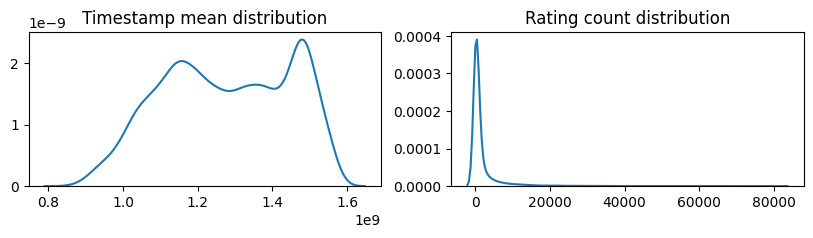

In [15]:
df = datasets[0]['data']

# print distribution for ratings
fig, axs = plt.subplots(1, 2, figsize=(10, 2))
sns.kdeplot(df['mean_timestamp'], ax=axs[0], palette='mako', label='timestamp')
sns.kdeplot(df['rating_count'], ax=axs[1], palette='mako', label='rating')

axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].title.set_text('Timestamp mean distribution')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].title.set_text('Rating count distribution')
plt.show()


Number of movies with rating_count < 50:  642
Number of all movies:  13816


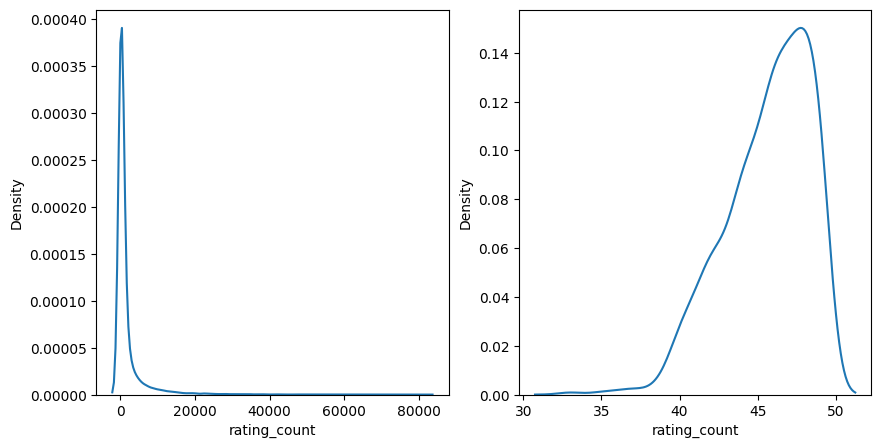

In [16]:
df = datasets[0]['data']

# density plot for rating_count
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count', palette='mako')
sns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50', palette='mako')

print('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])
print('Number of all movies: ', df.shape[0])


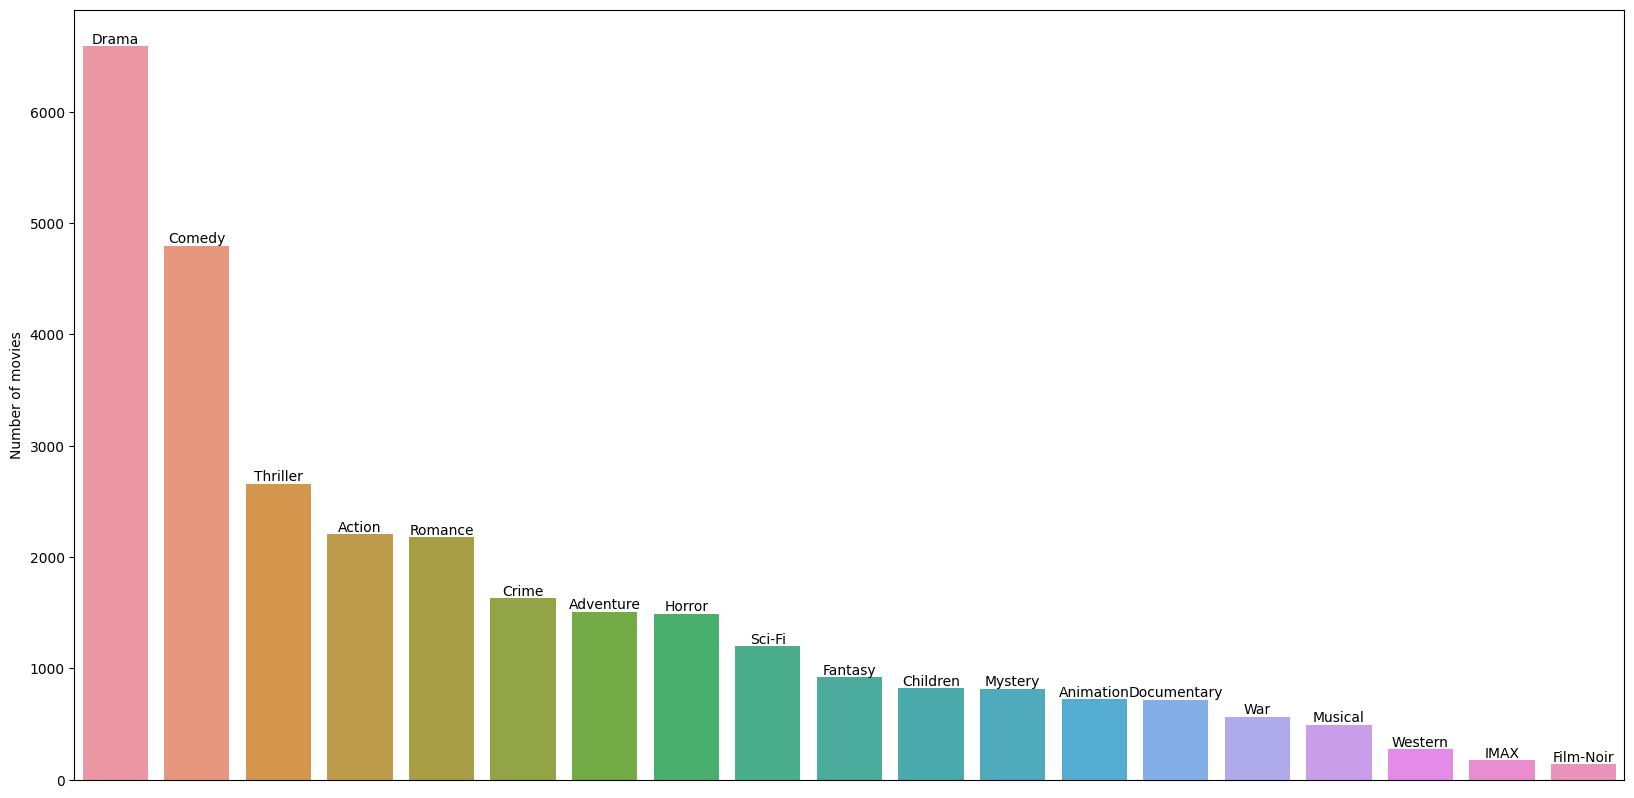

In [17]:
df = datasets[0]['data']

# plot for categories
cat = list(categories)

# count the number of rows containing 1 for each category
cat_dict = {}
for category in cat:
    cat_dict[category] = df[category].sum()

# order the dictionary by value in descending order
cat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}

# plot an histogram of the number of rows for each category
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))
ax.set_ylabel('Number of movies')
plt.xticks([])
plt.show()


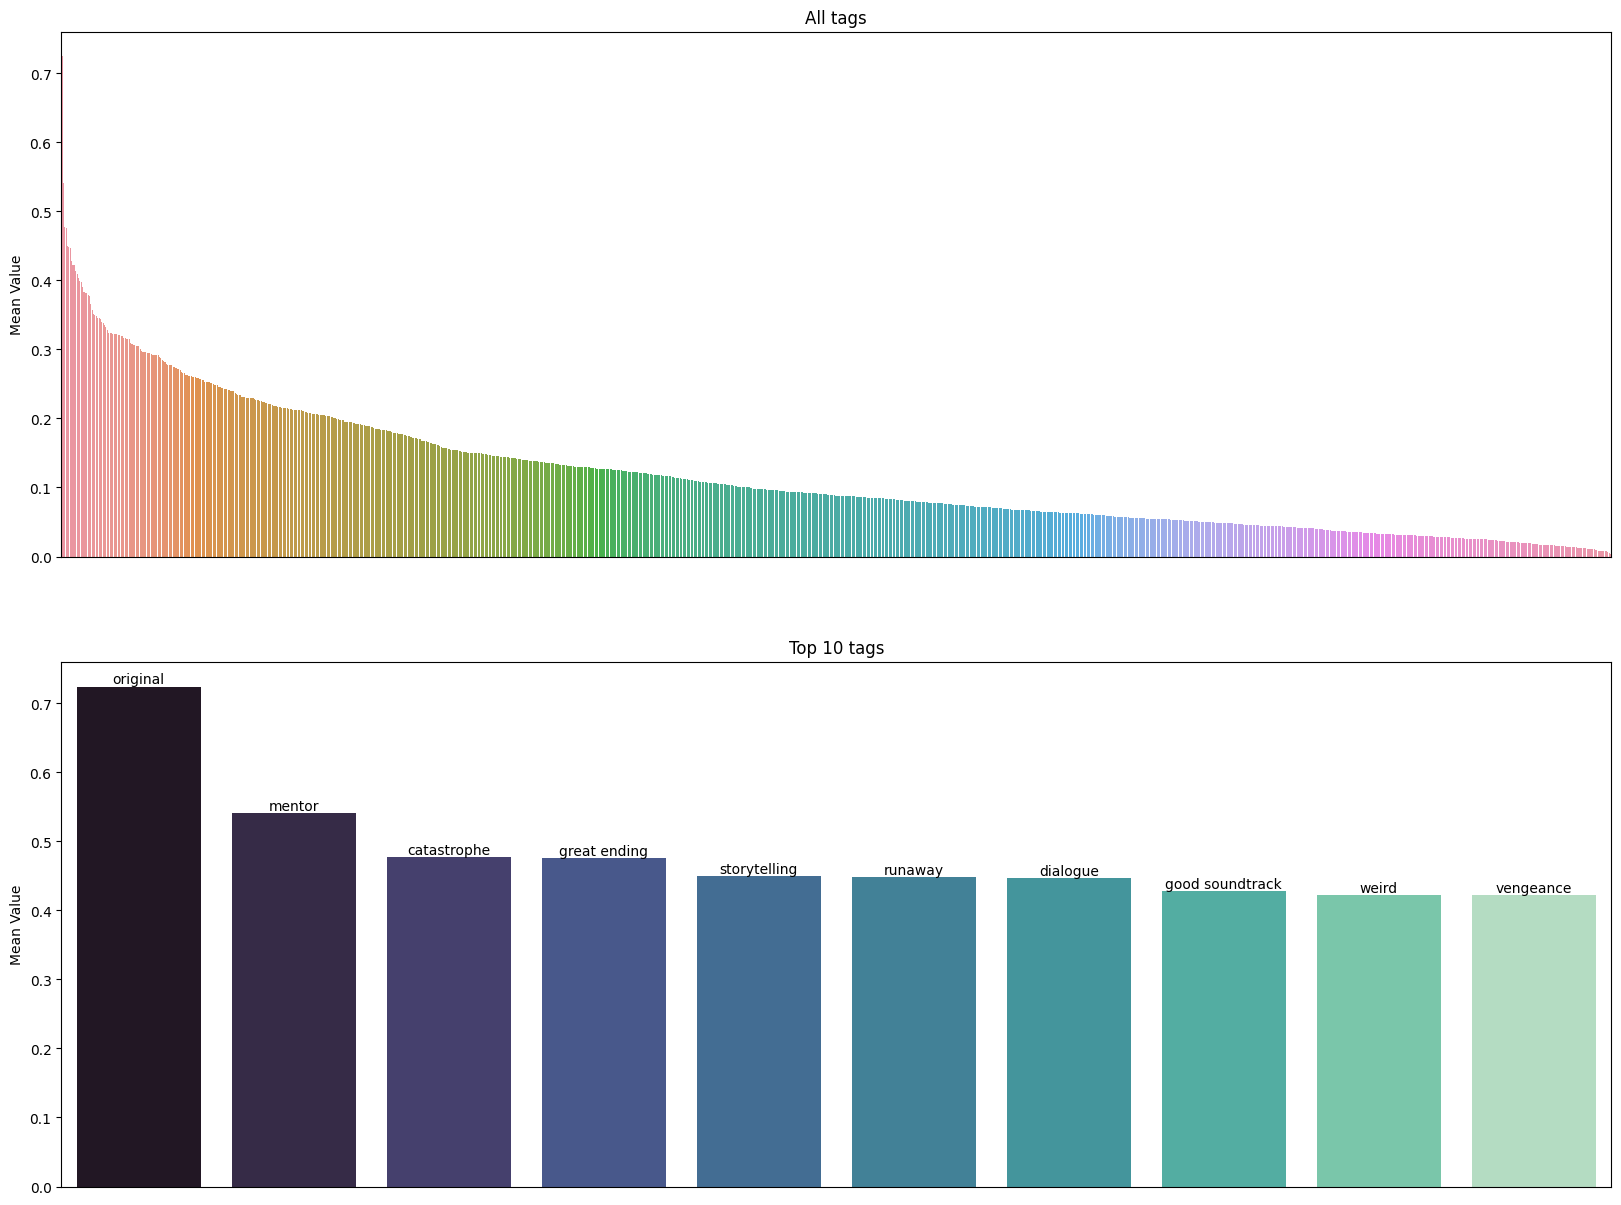

In [18]:
df = datasets[0]['data']

# plot for tags

tag_columns = list(df.columns)
tag_columns = df.drop(columns=['movieId','title','mean_rating','rating_count', 'mean_timestamp']).columns
tag_columns = [tag for tag in tag_columns if tag not in categories]

tag_dict = {}
for tag in tag_columns:
    tag_dict[tag] = df[tag].mean()

# order the dictionary by value in descending order and plot the first 10
tag_dict = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}

fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax1 = sns.barplot(x=list(tag_dict.keys())[:], y=list(tag_dict.values())[:] , ax=axs[0])
ax1.xaxis.set_ticks([])
ax1.set_title('All tags')
ax1.set_ylabel('Mean Value')
ax2 = sns.barplot(x=list(tag_dict.keys())[:10], y=list(tag_dict.values())[:10] , ax=axs[1], palette='mako')
ax2.bar_label(container=ax2.containers[0], labels=list(tag_dict.keys())[:10])
ax2.set_title('Top 10 tags')
ax2.set_ylabel('Mean Value')
plt.xticks([])
plt.show()


In [19]:
df = datasets[0]['data']

# count the number of rows containing 1 for Film-Noir and IMAX
print('Number of Film-Noir movies: ', df['Film-Noir'].sum())
print('Number of IMAX movies: ', df['IMAX'].sum())

Number of Film-Noir movies:  138
Number of IMAX movies:  173


## Data Preprocessing

In [11]:
datasets2 = copy.deepcopy(datasets)

In [12]:
datasets = copy.deepcopy(datasets2)

n = len(datasets)
for i in range(n):

    dataset = datasets[i]
    df = dataset['data']

    df_title = df['title']

    df = df.drop(columns=['movieId', 'title'])

    # from title extract year
    df['year'] = df_title.str.extract('(\(\d{4}\))', expand=True)
    # remove parentheses
    df['year'] = df['year'].str.extract('(\d{4})', expand=True)

    # remove movies with no year
    df = df.dropna(subset=['year'])

    # convert year to int
    df['year'] = df['year'].astype(int)

    datasets[i]['data'] = df
    
    datasets.append({'transform': dataset['transform'], 'threshold': dataset['threshold'], 'year': True, 'tags': dataset['tags'], 'genres': dataset['genres'], 'data': df, 'X_train': dataset['X_train'], 'X_val': dataset['X_val'], 'X_test': dataset['X_test'], 'y_train': dataset['y_train'], 'y_val': dataset['y_val'], 'y_test': dataset['y_test'], 'pca': dataset['pca']})

# remove datasets without year
datasets = datasets[n:]


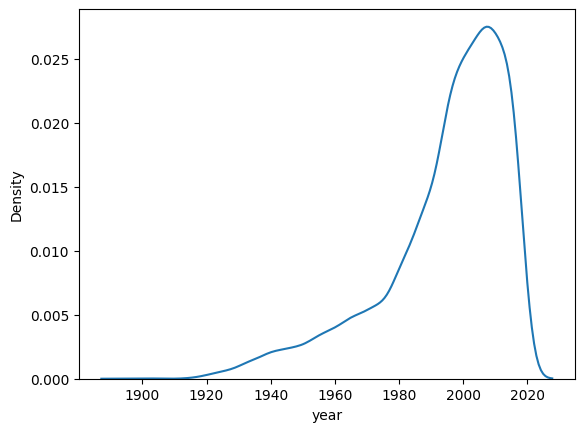

In [13]:
df = datasets[0]['data']

# density plot for film year
sns.kdeplot(df['year'], palette='mako')
plt.show()


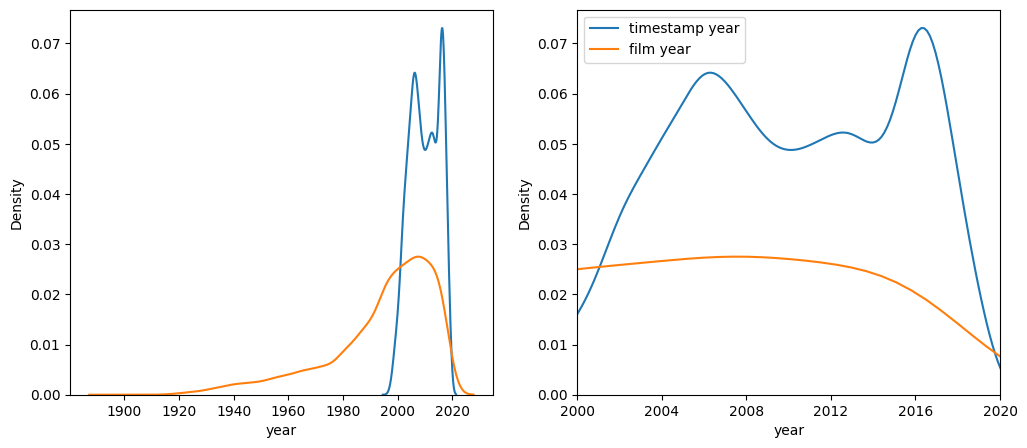

In [13]:
df = datasets[0]['data']

# show year and year_timestamp in the same plot
df_year = df.copy()
df_year['mean_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s')
df_year['year_timestamp'] = df_year['mean_timestamp'].dt.year

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.kdeplot(df_year['year_timestamp'], ax=axs[0], label='timestamp year', palette='mako')
sns.kdeplot(df_year['year'], ax=axs[0], label='film year', palette='mako')
axs[0].set_xlabel('year')
axs[0].set_label('year')
sns.kdeplot(df_year['year_timestamp'], ax=axs[1], label='timestamp year', palette='mako')
sns.kdeplot(df_year['year'], ax=axs[1], label='film year', palette='mako')
axs[1].set_xlabel('year')
axs[1].set_xlim(2000, 2020)
axs[1].set_xticks(np.arange(2000, 2022, 4))
axs[1].set_label('year_timestamp')
plt.legend()
plt.show()


In [14]:
# for each dataset with year, replace year with its corresponding rank in the range [0, M]
for i, dataset in enumerate(datasets):
    df = dataset['data']
    if df['year'].count() > 0:
        min = df['year'].min()
        df['year'] = df['year'] - min
        datasets[i]['data'] = df


### Correlation results
This correlation table shows the relationship between different movie genres and several movie characteristics such as mean rating, rating count, and year of release. The values in the table represent the Pearson correlation coefficient, which ranges from -1 to 1 and measures the linear association between two variables. Positive values indicate a positive association, meaning that as one variable increases, the other variable also increases. Negative values indicate a negative association, meaning that as one variable increases, the other variable decreases.

<!-- Some observations from the table:

There is a positive correlation between the mean rating and rating count of a movie (0.13). This indicates that movies with higher ratings tend to have more ratings.
Film-Noir has a moderate positive correlation with Crime (0.15) and Mystery (0.06). This suggests that movies classified as Film-Noir often have elements of crime and mystery.
Horror movies have a negative correlation with mean rating (-0.22), indicating that they tend to have lower ratings.
Drama movies have a moderate positive correlation with mean rating (0.15) and a moderate positive correlation with Thriller movies (0.24).
There is a negative correlation between year of release and rating count (-0.27), which suggests that older movies tend to have fewer ratings.
In conclusion, this table provides useful information about the relationship between different movie genres and movie characteristics, and can be used to make informed decisions about movie selection and production. -->

### Covariance results
Covariance is a measure of the linear relationship between two variables. It measures how changes in one variable are associated with changes in the other variable. Covariance is expressed as a numerical value and can range from negative to positive values. A positive covariance means that the two variables are positively related, while a negative covariance means that they are inversely related. A covariance of zero means that there is no linear relationship between the variables (i.e. variables are indipendent).

<!-- In the table provided, the covariance between two variables can be found in the entries of the matrix. For example, the covariance between "mean_rating" and "Film-Noir" is 0.001774, indicating a very small positive relationship between the two variables. The covariance between "rating_count" and "Crime" is 43.331685, indicating a stronger positive relationship between these two variables.

It's important to keep in mind that covariance only measures linear relationships, so it may not be able to fully capture more complex relationships between variables.

As it's possible to see in the table, variables tend to be indipendent from each others, this is not valid only for two variables: rating_count and mean_timestamp. These two attributes are highly dipendent with all other attributes. -->

### Dataset Describe
The describe() function applied on the Pandas DataFrame provides statistical information about the features in the DataFrame. 

<!-- According to the results, the mean rating for the movies is 3.110263, with a standard deviation of 0.653225. The minimum and maximum ratings are 0.5 and 5, respectively. The mean count of ratings for each movie is 596.81, with a standard deviation of 2929.96. -->

<!-- The genre columns (Film-Noir, Crime, Mystery, Animation, etc.) are binary, with a mean of either 0 or 0.01 to 0.28. The 25th, 50th, and 75th percentiles for these features are either 0 or close to 0, indicating that the majority of the movies belong to a particular genre. The year_timestamp feature has a mean of 2014.22, with a standard deviation of 4.7. The year feature has a mean of 1991.57 and a standard deviation of 25.09. -->

corr['year']:  -0.15404748209039545
corr['mean_timestamp']:  0.1369066181112574
corr['rating_count']:  0.20276809220561076


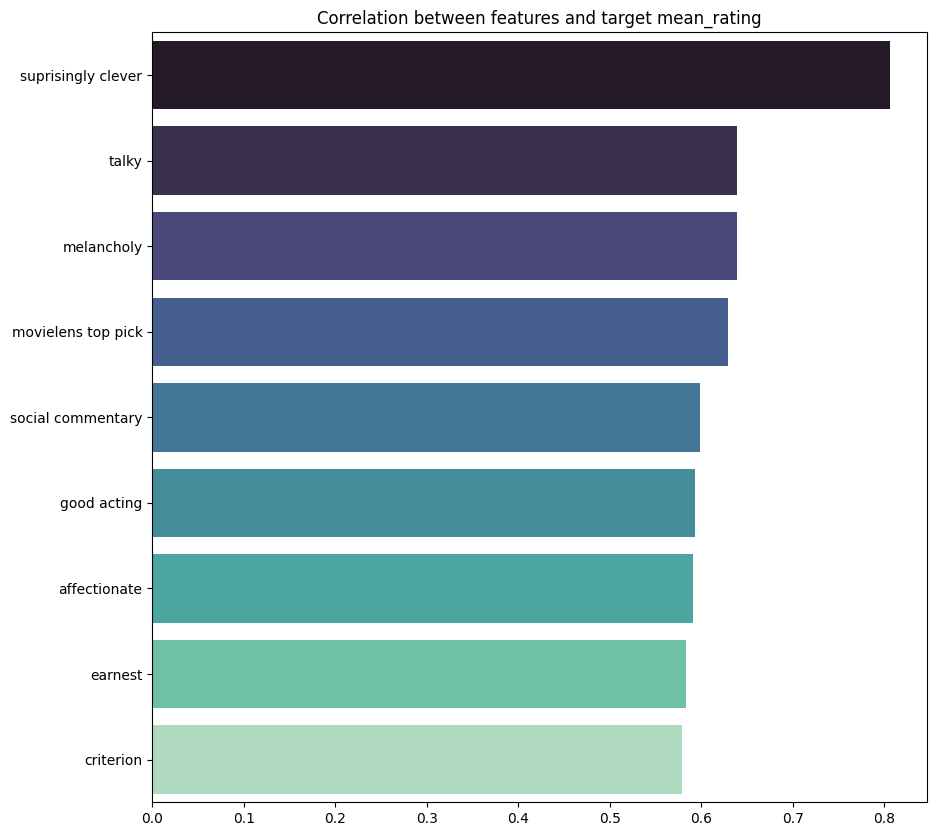

In [25]:
df = datasets[0]['data']

# plot correlation between features and target mean_rating
corr = df.corr()['mean_rating'].sort_values(ascending=False)

print("corr['year']: ", corr['year'])
print("corr['mean_timestamp']: ", corr['mean_timestamp'])
print("corr['rating_count']: ", corr['rating_count'])

# barplot features with highest correlation
plt.figure(figsize=(10, 10))
sns.barplot(x=corr[1:10].values, y=corr[1:10].index, palette='mako')
plt.title('Correlation between features and target mean_rating')
plt.show()

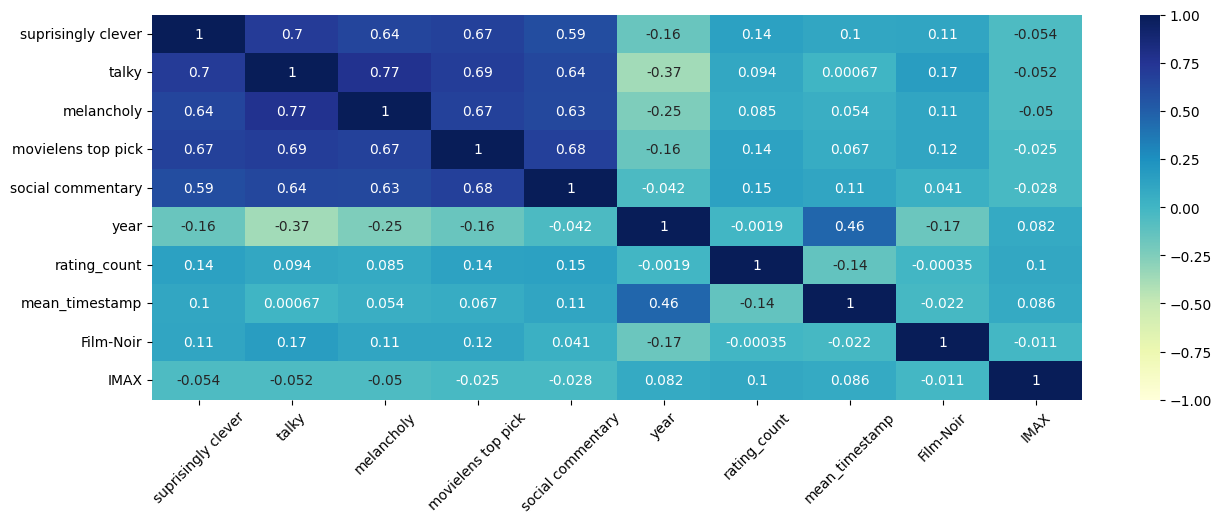

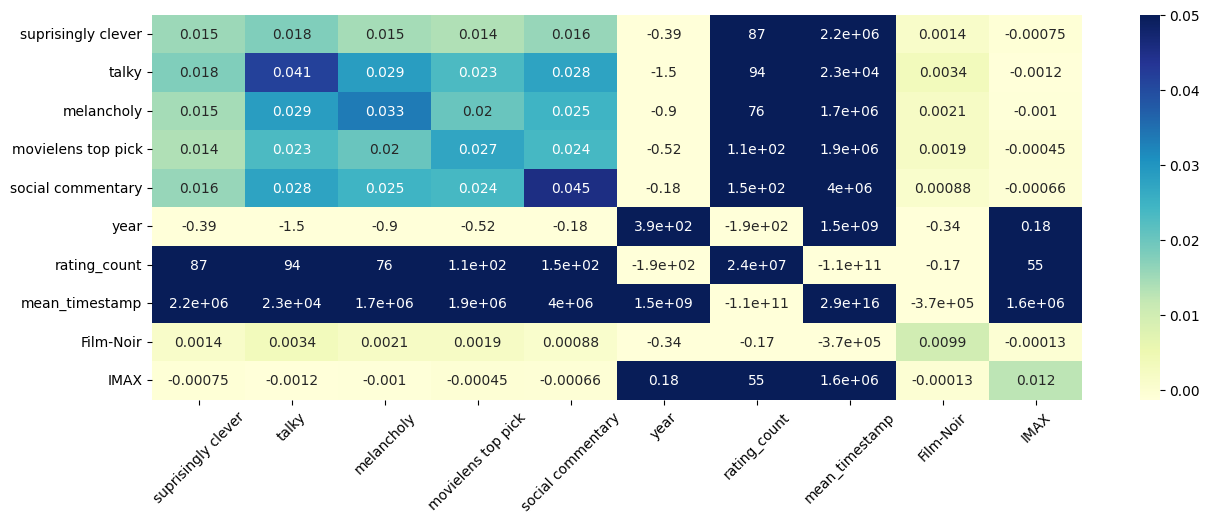

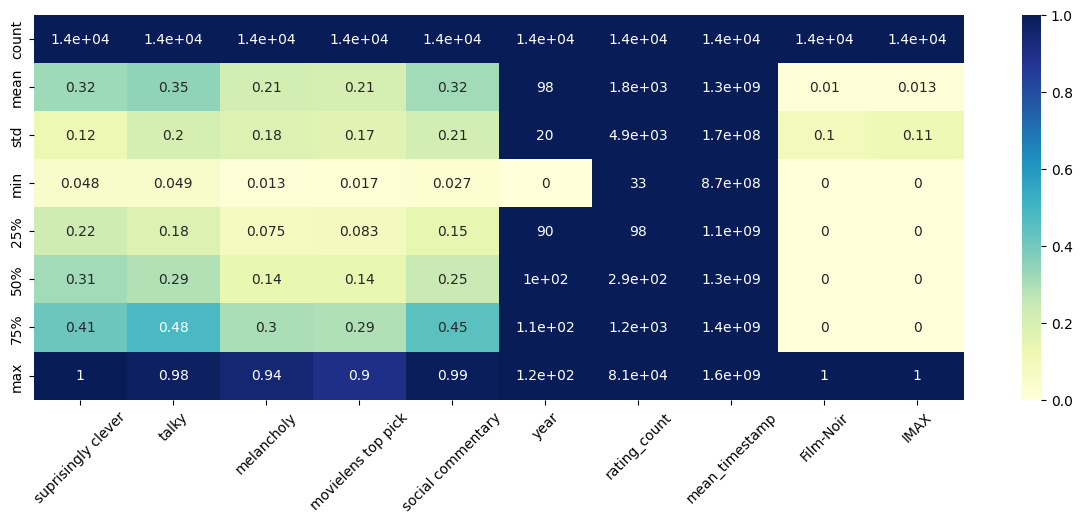

In [26]:
df = datasets[0]['data']

# compute analysis for 'mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX' and first 10 tags based on correlation
list_to_compute = list(corr[1:6].index)
list_to_compute.append('year')
list_to_compute.append('rating_count')
list_to_compute.append('mean_timestamp')
list_to_compute.append('Film-Noir')
list_to_compute.append('IMAX')

corr = df[list_to_compute].corr()
cov = df[list_to_compute].cov()
desc = df[list_to_compute].describe()

plt.figure(figsize=(15, 5))
sns.heatmap(corr, annot=True, cmap="YlGnBu", vmax=1, vmin=-1)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 5))
sns.heatmap(cov, annot=True, cmap="YlGnBu", vmax=-0.0012, vmin=0.05)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 5))
sns.heatmap(desc, annot=True, cmap='YlGnBu', vmax=1, vmin=0)
plt.xticks(rotation=45)
plt.show()


### Transformation

In [15]:
def split_data(df, mean_rating_column):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df, mean_rating_column, test_size=0.2, random_state=42)
    X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=42)
    return X_train_s, X_val_s, X_test_s, y_train_s, y_val_s, y_test_s

# create df from X_train, X_val, X_test, y_train, y_val, y_test
def create_df(X_train, X_val, X_test, y_train, y_val, y_test):
    df = pd.concat([X_train, X_val, X_test], axis=0)
    df = df.reset_index(drop=True)
    df['mean_rating'] = pd.concat([y_train, y_val, y_test], axis=0)
    df = df.reset_index(drop=True)
    return df

def normalize(df, mean_rating_column, type, i):
    columns = df.columns
    transformer = Normalizer(norm=type).fit(df)
    df = transformer.transform(df)
    df = pd.DataFrame(df, columns=columns)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, mean_rating_column)
    df = create_df(X_train, X_val, X_test, y_train, y_val, y_test)
    datasets.append({'transform': type+"_normalization", 'threshold': datasets[i]['threshold'], 'year': datasets[i]['year'], 'tags': datasets[i]['tags'], 'genres': datasets[i]['genres'], 'data': df, 'X_train': X_train, 'X_val': X_val, 'X_test': X_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test, 'pca': datasets[i]['pca']})

def scale(df, mean_rating_column, transformer, i):
    columns = df.columns
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, mean_rating_column)
    transformer.fit(X_train)
    X_train = transformer.transform(X_train)
    X_val = transformer.transform(X_val)
    X_test = transformer.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=columns)
    X_val = pd.DataFrame(X_val, columns=columns)
    X_test = pd.DataFrame(X_test, columns=columns)
    df = create_df(X_train, X_val, X_test, y_train, y_val, y_test)
    string = str(transformer).split('(')[0]
    datasets.append({'transform': string, 'threshold': datasets[i]['threshold'], 'year': datasets[i]['year'], 'tags': datasets[i]['tags'], 'genres': datasets[i]['genres'], 'data': df, 'X_train': X_train, 'X_val': X_val, 'X_test': X_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test, 'pca': datasets[i]['pca']})

def transform(df, mean_rating_column, transformation, i):
    df = df.to_numpy()
    df = df.astype(float)
    if transformation == 'sign_sqrt_normalization':
        df = np.sign(df) * np.sqrt(np.abs(df))
    df = pd.DataFrame(df, columns=columns)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, mean_rating_column)
    df = create_df(X_train, X_val, X_test, y_train, y_val, y_test)
    datasets.append({'transform': transformation, 'threshold': datasets[i]['threshold'], 'year': datasets[i]['year'], 'tags': datasets[i]['tags'], 'genres': datasets[i]['genres'], 'data': df, 'X_train': X_train, 'X_val': X_val, 'X_test': X_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test, 'pca': datasets[i]['pca']})

n = len(datasets)
for i in range(n):
    print('Dataset {}/{}'.format(i+1, n), end='\r')
    dataset = datasets[i]

    np.random.seed(42)
    df_general = dataset['data']
    mean_rating_column = df_general['mean_rating']
    df_general = df_general.drop(columns=['mean_rating'])
    columns = df_general.columns

    # L2 normalization
    df = copy.deepcopy(df_general)
    normalize(df, mean_rating_column, 'l2', i)

    # Sign Square Rooted normalization
    df = copy.deepcopy(df_general)
    transform(df, mean_rating_column, 'sign_sqrt_normalization', i)

    # L1 normalization
    df = copy.deepcopy(df_general)
    normalize(df, mean_rating_column, 'l1', i)

    # MinMaxScaler
    df = copy.deepcopy(df_general)
    scale(df, mean_rating_column, MinMaxScaler(), i)
    
    # Standardization
    df = copy.deepcopy(df_general)
    scale(df, mean_rating_column, StandardScaler(), i)

    # None : transform int columns to float columns
    df = copy.deepcopy(df_general)
    transform(df, mean_rating_column, 'None', i)

# remove datasets without transformation
datasets = datasets[n:] 
    

In [16]:
print('Number of datasets: {}'.format(len(datasets)))

# print last 6 datasets head
for dataset in datasets:
    print(dataset['transform'])
    df = pd.DataFrame(dataset['data'])
    # print only mean_rating, rating_count, year, mean_timestamp, 007, 1920s columns
    display(df[['rating_count', 'year', 'mean_timestamp', '007', '1920s']].head(2))

Number of datasets: 6
l2_normalization


,rating_count,year,mean_timestamp,007,1920s
0,2.187950e-06,9.832368e-08,1.0,2.582238e-11,9.335784e-11
1,1.369402e-07,7.825153e-08,1.0,1.572017e-11,2.515228e-11


sign_sqrt_normalization


,rating_count,year,mean_timestamp,007,1920s
0,46.936127,9.949874,31731.348254,0.161245,0.306594
1,14.000000,10.583005,37832.286463,0.150000,0.189737


l1_normalization


,rating_count,year,mean_timestamp,007,1920s
0,2.187945e-06,9.832345e-08,0.999998,2.582232e-11,9.335762e-11
1,1.369401e-07,7.825151e-08,1.000000,1.572017e-11,2.515227e-11


MinMaxScaler


,rating_count,year,mean_timestamp,007,1920s
0,0.026639,0.804878,0.191832,0.018644,0.091358
1,0.002001,0.910569,0.798481,0.015117,0.027709


StandardScaler


,rating_count,year,mean_timestamp,007,1920s
0,0.083978,0.037706,-1.590087,-0.288267,0.090330
1,-0.332880,0.686337,0.911860,-0.338839,-0.570968


None


,rating_count,year,mean_timestamp,007,1920s
0,2203.0,99.0,1.006878e+09,0.0260,0.094
1,196.0,112.0,1.431282e+09,0.0225,0.036


In [48]:
# PCA for dataset with transform = MinMaxScaler
dataset = next(item for item in datasets if item["transform"] == 'MinMaxScaler')
X_train = dataset['X_train']
X_test = dataset['X_test']
y_train = dataset['y_train']
y_test = dataset['y_test']

for prob in [1, 0.7, 0.95]:
    print('\nPCA with {}% of variance'.format(prob*100))

    pca = PCA(n_components=prob)
    X_train_centered = X_train
    pca.fit(X_train_centered)
    X_train_scores = pca.transform(X_train_centered)
    X_test_scores = pca.transform(X_test)

    model = LinearRegression().fit(X_train_scores, y_train)
    y_pred = model.predict(X_test_scores)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('MSE: {:.6f}'.format(mse))
    print('R2: {:.6f}'.format(r2))



PCA with 100% of variance
MSE: 0.101028
R2: 0.552100

PCA with 70.0% of variance
MSE: 0.015483
R2: 0.931356

PCA with 95.0% of variance
MSE: 0.006052
R2: 0.973167


In [35]:
X_train_scores_df = pd.DataFrame(X_train_scores)
X_train_scores_df = X_train_scores_df.set_axis (['PC{}'.format(i+1) for i in range(X_train_scores_df.shape[1])], axis=1)
X_train_scores_df = pd.concat([X_train_scores_df, y_train], axis=1)
display(X_train_scores_df.head())


# Proportion of variance each principal component
prop_variance = pca.explained_variance_ratio_
prop_variance_df = pd.DataFrame(prop_variance, columns=['Proportion of Explained Variance'])
# Add cumulative proportion of variance
cumulative_prop = np.cumsum(np.round(prop_variance, decimals=4))
cumulative_prop_df = pd.DataFrame(cumulative_prop, columns=['Cumulative Proportion of Variance'])
# Combine into one dataframe
pc_df = pd.DataFrame(['PC{}'.format(i+1) for i in range(X_train_scores_df.shape[1])], columns= ['Principal Component'])
variance_df = pd.concat([pc_df, prop_variance_df, cumulative_prop_df], axis=1)
display(variance_df.head())


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC536,PC537,PC538,PC539,PC540,PC541,PC542,PC543,PC544,mean_rating
0,0.777796,-0.269136,0.005754,0.416351,1.359822,-0.097848,0.117249,-0.182686,0.443818,0.407333,...,0.045000,-0.021851,-0.025730,-0.022077,-0.026174,-0.031582,-0.009185,-0.013312,-0.047836,3.893708
1,2.338329,1.705224,-1.212404,-1.923624,0.023340,-0.283664,1.663107,1.299241,0.040739,0.564546,...,-0.070802,-0.037153,-0.073803,-0.009013,0.083262,-0.048456,-0.132029,0.025692,-0.003215,3.251527
2,-1.052104,0.006029,-1.295496,0.808551,-0.448395,-0.252854,-1.402492,1.255691,0.214304,-0.490000,...,0.034410,-0.104868,-0.028223,0.018348,-0.127415,0.094076,-0.018142,0.001962,0.045329,3.142028
3,0.004038,1.551649,0.515983,-0.479575,2.439349,-1.595644,0.480602,0.384613,0.344861,0.100994,...,0.053891,0.049350,-0.080226,-0.055202,0.007488,-0.061343,-0.056130,-0.037957,0.104718,2.853547
4,-0.628744,-0.948639,1.075416,-0.177658,-0.095263,-0.368873,0.163432,0.419891,-0.273912,-0.982712,...,0.019529,0.043715,0.003672,0.003599,-0.132163,-0.022454,0.033362,0.086206,-0.154055,3.058434


,Principal Component,Proportion of Explained Variance,Cumulative Proportion of Variance
0,PC1,0.144268,0.1443
1,PC2,0.072958,0.2173
2,PC3,0.059132,0.2764
3,PC4,0.038901,0.3153
4,PC5,0.036857,0.3522


Text(0.5, 1.0, 'CEV for first 10 Principal Components')

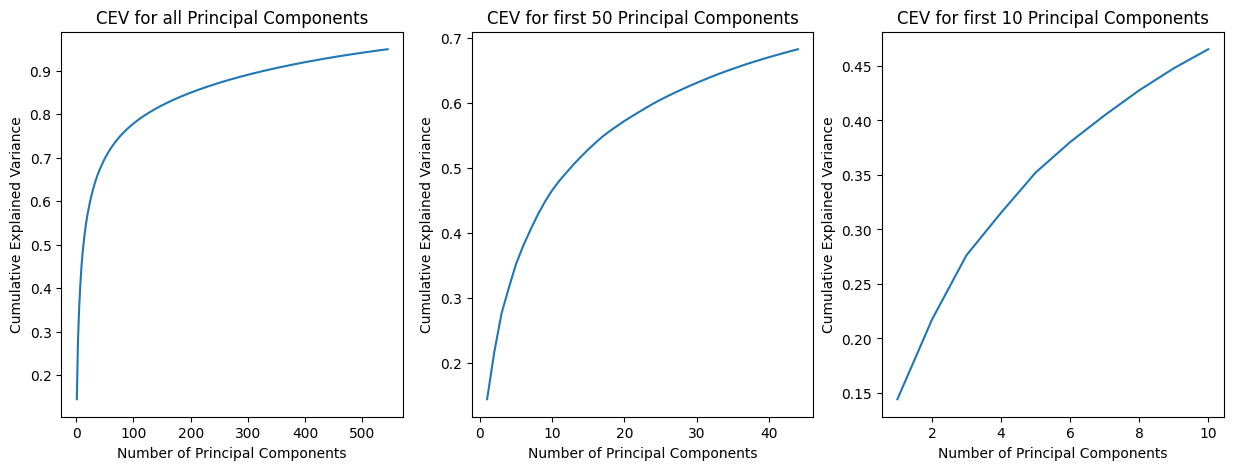

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# lineplot of the cumulative explained variance
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
sns.lineplot(x=[i for i in range(1, len(exp_var_cumul)+1)], y=exp_var_cumul, ax=ax[0])

# lineplot of the first 50 principal components
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
sns.lineplot(x=[i for i in range(1, 45)], y=exp_var_cumul[:44], ax=ax[1])

# lineplot of the first 10 principal components
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
sns.lineplot(x=[i for i in range(1, 11)], y=exp_var_cumul[:10], ax=ax[2])

# set x and y labels
ax[0].set_xlabel('Number of Principal Components')
ax[0].set_ylabel('Cumulative Explained Variance')
ax[0].set_title('CEV for all Principal Components')
ax[1].set_xlabel('Number of Principal Components')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].set_title('CEV for first 50 Principal Components')
ax[2].set_xlabel('Number of Principal Components')
ax[2].set_ylabel('Cumulative Explained Variance')
ax[2].set_title('CEV for first 10 Principal Components')


### TSNE

In [331]:
X_train = next(item for item in datasets if item["transform"] == 'MinMaxScaler')['X_train']
perplexities = [5, 30, 50, 100]
tsne = [None] * len(perplexities)
X_train_TSNE = [None] * len(perplexities)
for i, p in enumerate(perplexities):
    print('Perplexity: {}'.format(p))
    tsne[i] = TSNE(n_components=2, init='random', random_state=42, perplexity=p)
    tsne[i] = tsne[i].fit(X_train)
    X_train_TSNE[i] = tsne[i].fit_transform(X_train)
y_train = datasets[0]['y_train']


Perplexity: 5
Perplexity: 30
Perplexity: 50
Perplexity: 100


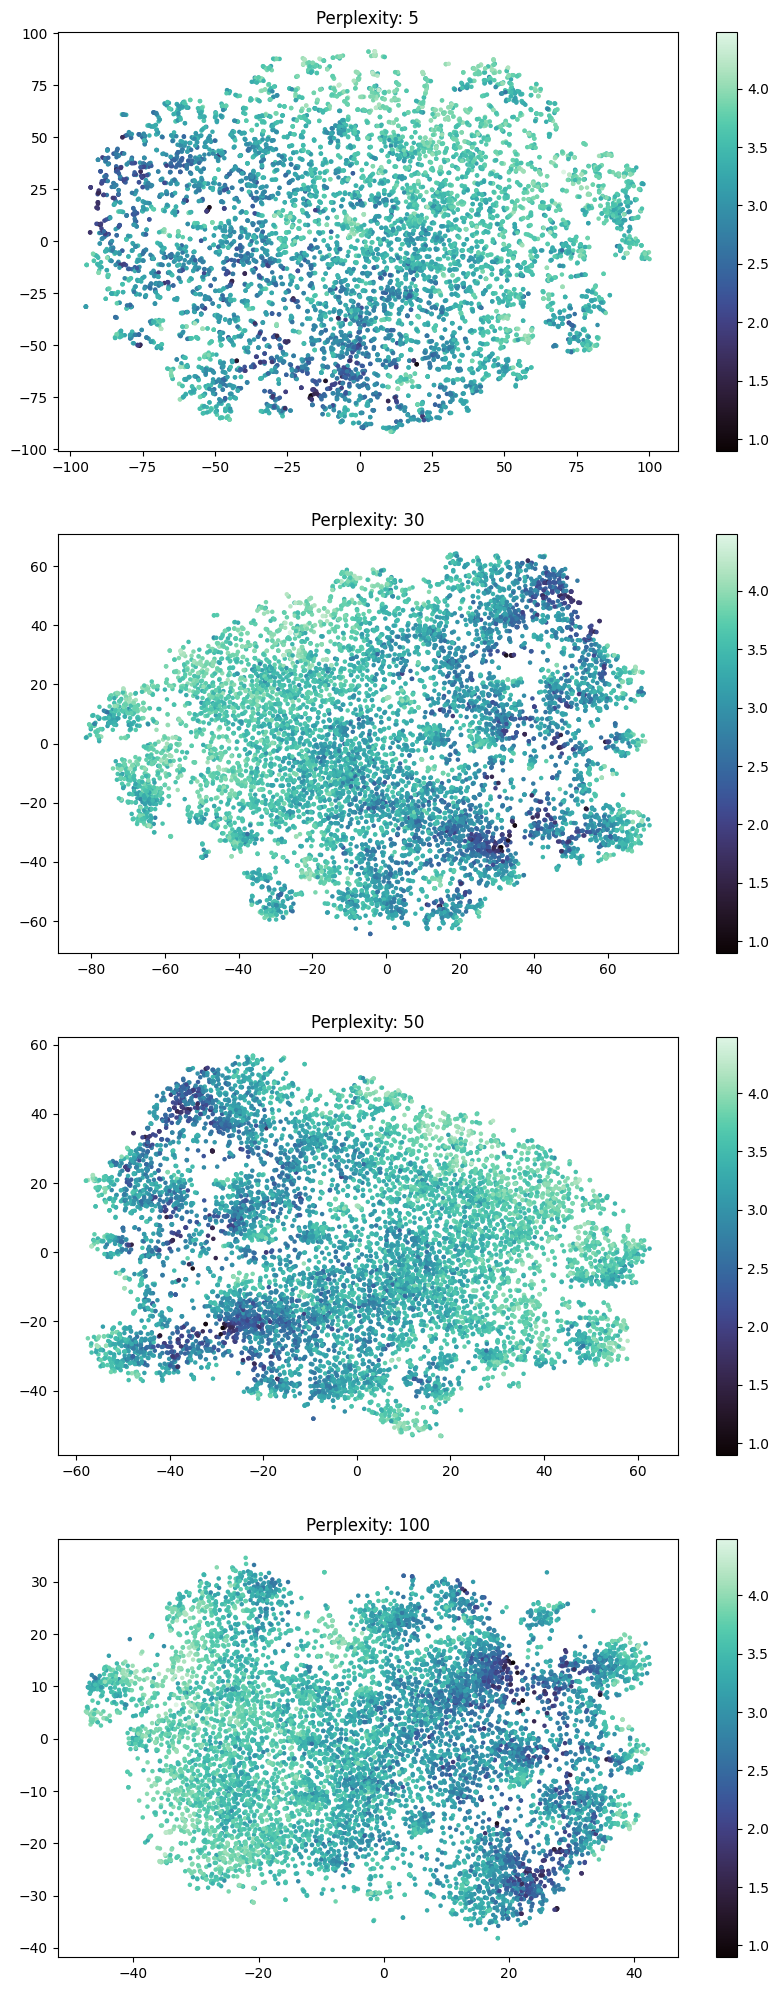

In [332]:
fig, axs = plt.subplots(len(perplexities), 1, figsize=(10, 25))
for i, p in enumerate(perplexities):
    fig.colorbar(axs[i].scatter(X_train_TSNE[i][:, 0], X_train_TSNE[i][:, 1], c=y_train, cmap='mako', s=5), ax=axs[i])
    axs[i].set_title('Perplexity: {}'.format(p))
plt.show()

## Modeling

In [18]:
def plot_model_results(hgs, model_name):
    # get all scores of candidates over iterations
    hgs_results = pd.DataFrame(hgs.cv_results_)

    # drop rows with iter < max
    hgs_results = hgs_results[hgs_results['iter'] == hgs_results['iter'].max()]
    # drop all columns except mean_test_score, iter and those that start with 'param_'
    hgs_results = hgs_results[[col for col in hgs_results.columns if col.startswith('param_') or col in ['iter','mean_test_score']]]
    # set param_n_jobs to 8 instead of -1
    hgs_results['param_n_jobs'] = 8
    # rename mean_test_score to mse and transform to positive
    if model_name == 'RandomForestClassification':
        hgs_results['accuracy'] = hgs_results['mean_test_score']
        hgs_results = hgs_results.sort_values(by='accuracy')
    else:
        hgs_results['mse'] = -hgs_results['mean_test_score']
        hgs_results = hgs_results.sort_values(by='mse')
    hgs_results = hgs_results.drop('mean_test_score', axis=1)
    hgs_results = hgs_results.reset_index(drop=True)
    display(hgs_results)


    # add results to tensorboard
    writer = SummaryWriter('based_models/{}'.format(model_name))
    # for all rows add mse column as scalar and columns that start with param_ as hparams
    for _, row in hgs_results.iterrows():
        hparams = {key: str(value) for key, value in row.items() if key.startswith('param_')}
        if model_name == 'RandomForestClassification':
            writer.add_hparams(hparams, {'accuracy': row['accuracy']})
        else:
            writer.add_hparams(hparams, {'mse': row['mse']})
        writer.flush()
    writer.close()
    

    return hgs_results


In [19]:
dataset = next(item for item in datasets if item["transform"] == 'MinMaxScaler')

X = dataset['X_train']
y = dataset['y_train']
X_test = dataset['X_test']
y_test = dataset['y_test']


#### Linear Regressor

In [73]:
rng = np.random.RandomState(0)

model = LinearRegression()

param_grid = {
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=0, cv=5, scoring='neg_mean_squared_error'
)
hgs.fit(X, y)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))

hgs_results = plot_model_results(hgs, 'LinearRegression')

# test model
y_pred = hgs.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on test set: {:.6f}'.format(mse))




Best MSE: 0.005573


,iter,param_n_jobs,mse
0,0,8,0.005573


MSE on test set: 0.005392


#### SVM

In [75]:
rng = np.random.RandomState(0)

model = SVR()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.001, 0.01, 0.1, 1, 10],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X, y)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))

hgs_results = plot_model_results(hgs, 'SVR')

# test model
y_pred = hgs.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on test set: {:.6f}'.format(mse))


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 327
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 75
n_resources: 327
Fitting 2 folds for each of 75 candidates, totalling 150 fits
[CV 1/2] END C=0.001, epsilon=0.001, kernel=linear;, score=(train=-0.108, test=-0.106) total time=   0.0s
[CV 2/2] END C=0.001, epsilon=0.001, kernel=linear;, score=(train=-0.129, test=-0.081) total time=   0.0s
[CV 1/2] END C=0.001, epsilon=0.001, kernel=poly;, score=(train=-0.209, test=-0.191) total time=   0.0s
[CV 2/2] END C=0.001, epsilon=0.001, kernel=poly;, score=(train=-0.240, test=-0.155) total time=   0.0s
[CV 1/2] END C=0.001, epsilon=0.001, kernel=rbf;, score=(train=-0.232, test=-0.213) total time=   0.0s
[CV 2/2] END C=0.001, epsilon=0.001, kernel=rbf;, score=(train=-0.266, test=-0.179) total time=   0.0s
[CV 1/2] END C=0.001, epsilon=0.01, kernel=linear;, score=(train=-0.107, test=-0.106) total time=   0.0s
[CV 2/2

,iter,param_C,param_epsilon,param_kernel,param_n_jobs,mse
0,3,0.1,0.1,linear,8,0.007138
1,3,1,0.1,linear,8,0.008528
2,3,10,0.1,linear,8,0.009083


MSE on test set: 0.005866


### KNN

In [76]:
rng = np.random.RandomState(0)

model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': np.arange(1, 21),
    'weights': ['uniform', 'distance']
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=0, cv=5, scoring='neg_mean_squared_error'
)
hgs.fit(X, y)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'KNeighborsRegressor')

# test model
y_pred = hgs.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on test set: {:.6f}'.format(mse))



Best MSE: 0.046106
Best parameters: {'n_neighbors': 9, 'weights': 'distance'}


,iter,param_n_neighbors,param_weights,param_n_jobs,mse
0,3,9,distance,8,0.046106
1,3,8,distance,8,0.046256


MSE on test set: 0.043560


### Decision Trees

In [77]:
rng = np.random.RandomState(0)

model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=0, cv=5, scoring='neg_mean_squared_error'
)
hgs.fit(X, y)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'DecisionTreeRegressor')

# test model
y_pred = hgs.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on test set: {:.6f}'.format(mse))


Best MSE: 0.034937
Best parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6}


,iter,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_jobs,mse
0,4,5,auto,3,6,8,0.034937


MSE on test set: 0.033715


### Ridge

In [78]:
rng = np.random.RandomState(0)

model = Ridge()

param_grid = {
    'alpha': [0.1, 1, 10],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=0, cv=5, scoring='neg_mean_squared_error'
)
hgs.fit(X, y)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'Ridge')


# test model
y_pred = hgs.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on test set: {:.6f}'.format(mse))


Best MSE: 0.005417
Best parameters: {'alpha': 10}


,iter,param_alpha,param_n_jobs,mse
0,1,10,8,0.005417


MSE on test set: 0.005221


### Lasso

In [79]:
rng = np.random.RandomState(0)

model = Lasso()

param_grid = {
    'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=0, cv=5, scoring='neg_mean_squared_error'
)
hgs.fit(X, y)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'Lasso')


# test model
y_pred = hgs.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on test set: {:.6f}'.format(mse))


Best MSE: 0.005482
Best parameters: {'alpha': 1e-05}


,iter,param_alpha,param_n_jobs,mse
0,1,0.00001,8,0.005482
1,1,0.0001,8,0.005583


MSE on test set: 0.005325


### ElasticNet

In [80]:
rng = np.random.RandomState(0)

model = ElasticNet()

param_grid = {
    'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=0, cv=5, scoring='neg_mean_squared_error'
)
hgs.fit(X, y)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'ElasticNet')


# test model
y_pred = hgs.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on test set: {:.6f}'.format(mse))


Best MSE: 0.005295
Best parameters: {'alpha': 0.0001}


,iter,param_alpha,param_n_jobs,mse
0,1,0.0001,8,0.005295
1,1,0.001,8,0.007940


MSE on test set: 0.005196


### Random Forest Regressor

In [82]:
rng = np.random.RandomState(0)

model = RandomForestRegressor()

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2']
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X, y)


print("\nBest MSE: {:.6f}".format(-hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'RandomForestRegressor')


# test model
y_pred = hgs.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on test set: {:.6f}'.format(mse))

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 327
max_resources_: 8830
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 327
Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV 1/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=-0.012, test=-0.050) total time=   0.5s
[CV 2/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=-0.008, test=-0.037) total time=   0.5s
[CV 1/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=-0.008, test=-0.036) total time=   2.2s
[CV 2/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=-0.007, test=-0.031) total time=   2.1s
[CV 1/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score

,iter,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_n_jobs,mse
0,3,5,auto,2,4,100,8,0.022738
1,3,5,auto,2,4,50,8,0.023122


MSE on test set: 0.022489


### Modeling the problem as classification

In [86]:
# bin y_train and y_test into 10 bins
y_binned = pd.cut(y, 10, labels=False)
y_test_binned = pd.cut(y_test, 10, labels=False)


rng = np.random.RandomState(0)

model = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50, 100],
    'min_samples_split': [5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=0, cv=5, scoring='accuracy'
)
hgs.fit(X, y_binned)



print("\nBest Accuracy: {:.6f}".format(hgs.best_score_))
print("Best parameters: {}".format(hgs.best_params_))


hgs_results = plot_model_results(hgs, 'RandomForestClassification')

# test model
y_pred = hgs.predict(X_test)
accuracy = accuracy_score(y_test_binned, y_pred)
print('Accuracy on test set: {:.6f}'.format(accuracy))



Best Accuracy: 0.728952
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


,iter,param_criterion,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_n_jobs,accuracy
0,3,entropy,auto,2,5,100,8,0.728952
1,3,entropy,sqrt,1,5,100,8,0.728952


Accuracy on test set: 0.637319


### Neural Network

In [20]:
# Selection of the dataset to test
# i = index of the dataset in datasets where transform = 'MinMaxScaler'
i = datasets.index(next((item for item in datasets if item["transform"] == 'MinMaxScaler'), None))
print('i = ', i)

X_train = datasets[i]['X_train']
y_train = datasets[i]['y_train']
X_test = datasets[i]['X_test']
y_test = datasets[i]['y_test']
X_val = datasets[i]['X_val']
y_val = datasets[i]['y_val']

i =  3


In [21]:
#look for GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Device: {}".format(device))


Device: mps


In [22]:
# Fix random seed
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)


In [23]:
# Definition of the training process
def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, writer, scheduler):
    patience = 20
    best_loss = np.inf
    best_model = None
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        mean_loss = 0
        # per verificare che ci troviamo in training e non in validation per evitare che il modello aggiorni i pesi
        for data, targets in data_loader:
            # per spostare il minibatch in GPU
            data, targets = data.to(device), targets.to(device)
            # Forward pass -> chiama la funzione forward
            y_pred = model(data)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), targets)
            mean_loss += loss.item()
            # serve per azzerare il gradiente
            optimizer.zero_grad()
            # la barra separa Loss e la sezione train
            # Backward pass
            loss.backward()
            optimizer.step()
        train_loss = mean_loss/len(data_loader)
        writer.add_scalar("Loss/train", train_loss, epoch)

        
        # validation
        loss_val, _, _ = test_model(model, criterion, val_loader, device)

        # early stopping
        if loss_val <= best_loss:
            best_loss = loss_val
            best_model = copy.deepcopy(model)
            best_epoch = epoch+1
            patience = 20
        else:
            patience = patience - 1
            if patience == 0:
                print("\nEarly stopping", end='')
                return best_model, best_epoch

        if best_loss == np.inf:
            print("No validation loss available", end='\n')
            return model, epoch
        
        print("Epoch: [ {} / {} ],\tPatience: {},\tBest loss: {:.6f},\tVal Loss: {:.6f},\tTrain Loss: {:.6f}".format(epoch+1, epochs, patience, best_loss, loss_val, train_loss), end='\r')
        writer.add_scalar("Loss/val", loss_val, epoch)

        scheduler.step()
    
    return best_model, best_epoch



#evaluation process -> utilizzata sia per la validation che per il test
def test_model(model, criterion, data_loader, device):
    model.eval() # per evitare che il modello aggiorni i pesi
    loss = 0
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    
    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)
        output = model(data)
        loss += criterion(output.squeeze(), targets)
        y_pred = torch.cat((y_pred, output), 0)
        y_true = torch.cat((y_true, targets), 0)

    return loss/len(data_loader), y_pred.squeeze(), y_true

In [33]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0):
        super(NN, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.dp = dropout_prob
        
        model = [
            nn.Linear(self.input_size, self.hidden_sizes[0]),
            nn.ReLU(),
            # nn.BatchNorm1d(self.hidden_sizes[0]),
            nn.Dropout(self.dp)
        ]
        
        for i in range(1, len(self.hidden_sizes)):
            model.append(nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
            model.append(nn.ReLU())
            # model.append(nn.BatchNorm1d(self.hidden_sizes[i]))
            model.append(nn.Dropout(self.dp))
        
        model.append(nn.Linear(self.hidden_sizes[-1], 1))
        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x.squeeze()


In [34]:
class RatingDataset(Dataset):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        
        self.num_features = X_train.shape[1]
        
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy()
        self.X_val = X_val.to_numpy()
        self.y_val = y_val.to_numpy()
        self.X_test = X_test.to_numpy()
        self.y_test = y_test.to_numpy()
    
    def get_train_loader(self, batch_size):
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_train, dtype=torch.float32), torch.tensor(self.y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
    
    def get_val_test_loaders(self):
        val = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_val, dtype=torch.float32), torch.tensor(self.y_val, dtype=torch.float32)), batch_size=self.X_val.shape[0], shuffle=False)
        test = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_test, dtype=torch.float32), torch.tensor(self.y_test, dtype=torch.float32)), batch_size=self.X_test.shape[0], shuffle=False)
        return val, test


In [35]:
# Setting Hyperparameters
hidden_sizes = [[64, 128, 64]]
batch_sizes = [32]
learning_rate = [0.001]
dropout_prob = [0.0]

nums_epochs = [200]

hyperparameters = itertools.product(hidden_sizes, nums_epochs, batch_sizes, learning_rate, dropout_prob)
device = torch.device("cpu")

In [36]:
# data
my_dataset = RatingDataset(X_train, y_train, X_val, y_val, X_test, y_test)

my_table = pd.DataFrame(columns=['hidden_size', 'num_epochs', 'batch_size', 'learning_rate', 'dropout_prob', 'MSE', 'R2'])

#grid search loop
for i, [hidden_size, num_epochs, batch, learning_rate, dropout_prob] in enumerate(hyperparameters):
    
    val_loader, test_loader = my_dataset.get_val_test_loaders()
    print("Iter: {}, hidden_size: {}, num_epochs: {}, batch_size: {}, learning_rate: {}, dropout_prob: {}".format(i+1, hidden_size, num_epochs, batch, learning_rate, dropout_prob))

    log_name = "dim:"+str(hidden_size)+"-ep:"+str(num_epochs)+"-bs:"+str(batch) + "-lr:"+str(learning_rate) + "-dp:"+str(dropout_prob)

    train_loader = my_dataset.get_train_loader(batch)

    model = NN(my_dataset.num_features, hidden_size, dropout_prob)

    criterion = torch.nn.MSELoss()

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    writer = SummaryWriter('runs/'+log_name)

    model, n_epochs = train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, writer, scheduler)

    mse, y_t, y_p = test_model(model, criterion, test_loader, device)
    r2 = r2_score(y_t.cpu().detach().numpy(), y_p.cpu().detach().numpy())
    print("\nMSE: ", mse.item())
    print("R2: {}".format(r2))
    
    
    my_table.loc[my_table.shape[0]] = [hidden_size, n_epochs, batch, learning_rate, dropout_prob, mse.item(), r2]
    writer.add_scalar('metrics/test mse', mse.item())
    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(model.state_dict(), 'models/'+log_name)

    writer.add_hparams(
        {'lr': learning_rate, 'bsize': batch, 'dim': str(hidden_size), 'num_epochs': n_epochs, 'dropout_prob': dropout_prob},
        {'hparam/mse': mse.item(), 'hparam/r2': r2}
    )

    writer.flush()
    
    
writer.close()


Iter: 1, hidden_size: [64, 128, 64], num_epochs: 200, batch_size: 32, learning_rate: 0.001, dropout_prob: 0.0
Epoch: [ 55 / 200 ],	Patience: 1,	Best loss: 0.004861,	Val Loss: 0.005048,	Train Loss: 0.0013200
Early stopping
MSE:  0.004918584134429693
R2: 0.9776217005919889


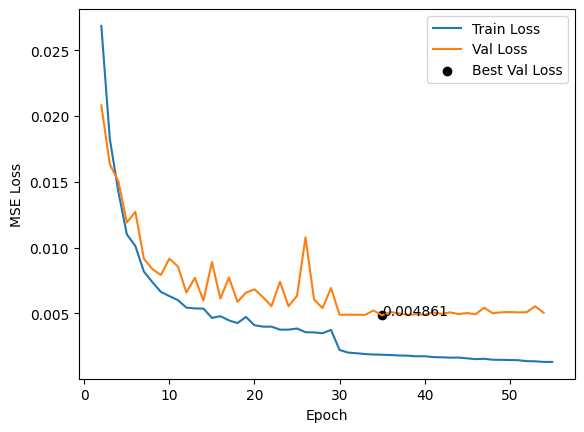

In [37]:
# concat run-dim_[64, 128, 64]-ep_200-bs_32-lr_0.001-dp_0.0-tag-Loss_train.csv and run-dim_[64, 128, 64]-ep_200-bs_32-lr_0.001-dp_0.0-tag-Loss_val.csv
file1 = pd.read_csv('run-dim_[64, 128, 64]-ep_200-bs_32-lr_0.001-dp_0.0-tag-Loss_train.csv')
file2 = pd.read_csv('run-dim_[64, 128, 64]-ep_200-bs_32-lr_0.001-dp_0.0-tag-Loss_val.csv')

file1['val'] = file2['Value']

# rename columns
file1.columns = ['Time', 'Step', 'Train_Loss', 'Val_Loss']

# plot only step 2 to 50
plt.plot(file1['Step'][2:], file1['Train_Loss'][2:], label='Train Loss')
plt.plot(file1['Step'][2:], file1['Val_Loss'][2:], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
# add point for best val loss and train loss
plt.scatter(file1['Step'][file1['Val_Loss'].idxmin()], file1['Val_Loss'].min(), label='Best Val Loss', color='black')
# add loss value for best val loss and train loss
plt.annotate(str(round(file1['Val_Loss'].min(), 6)), (file1['Step'][file1['Val_Loss'].idxmin()], file1['Val_Loss'].min()))
plt.legend()


In [38]:
# get model with best loss
best_model = NN(my_dataset.num_features, [64, 128, 64], 0.0)
best_model.load_state_dict(torch.load('models/dim:[64, 128, 64]-ep:200-bs:32-lr:0.001-dp:0.0'))
best_model.to(device)

mse, y_t, y_p = test_model(best_model, criterion, test_loader, device)
r2 = r2_score(y_t.cpu().detach().numpy(), y_p.cpu().detach().numpy())
print("\nMSE: ", mse.item())
print("R2: {}".format(r2))



MSE:  0.004918584134429693
R2: 0.9776217005919889


### TabNet

In [17]:
df = datasets[1]

X_train = df['X_train'].to_numpy()
X_test = df['X_test'].to_numpy()
X_val = df['X_val'].to_numpy()
y_train = df['y_train'].to_numpy()
y_test = df['y_test'].to_numpy()
y_val = df['y_val'].to_numpy()

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [ ]:
# Tuning hyperparameters
# batch_sizes = [128, 256]
# n_a = [8, 16, 32]
# n_d = [8, 16, 32]

# Best configuration found
batch_sizes = [128]
n_a = [16]
n_d = [8]

hyperparameters = list(itertools.product(batch_sizes, n_a, n_d))

In [ ]:
for bs, na, nd in hyperparameters:
    print(f"Testing configuration batch_size={bs}, n_a={na}, n_d={nd}")
    tabnet_model = TabNetRegressor(
        n_a=na,
        n_d=nd,
        verbose=0
    )

    tabnet_model.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_name=['validation'],
        batch_size=bs,
    )
    
    # evaluate model
    y_pred = tabnet_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('MSE:', mse)
    print('R2 Score:', r2)
    print('#'*50)
    print()

Testing configuration batch_size=128, n_a=16, n_d=8

Early stopping occurred at epoch 37 with best_epoch = 27 and best_validation_mse = 0.00608
MSE: 0.005884382847695725
R2 Score: 0.9739120622551057
##################################################



In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
# saved_filepath = tabnet_model.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_model = TabNetRegressor()
loaded_model.load_model(saving_path_name + ".zip")

In [ ]:
y_pred = loaded_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R2 Score:', r2)

MSE: 0.005884382847695725
R2 Score: 0.9739120622551057


In [19]:
# import TabNetPretrainer
from pytorch_tabnet.pretraining import TabNetPretrainer

bs = 128
na = 16
nd = 8

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_val],
    pretraining_ratio=0.8,
)

print(f"Testing configuration batch_size={bs}, n_a={na}, n_d={nd}")
tabnet_model = TabNetRegressor(
    n_a=na,
    n_d=nd,
    verbose=0
)

tabnet_model.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_val, y_val)],
    eval_name=['validation'],
    batch_size=bs,
)

# evaluate model
y_pred = tabnet_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R2 Score:', r2)
print('#'*50)
print()

epoch 0  | loss: 180.81924| val_0_unsup_loss_numpy: 10.674010276794434|  0:00:02s
epoch 1  | loss: 37.35468| val_0_unsup_loss_numpy: 8.290010452270508|  0:00:05s
epoch 2  | loss: 11.91938| val_0_unsup_loss_numpy: 4.986330032348633|  0:00:07s
epoch 3  | loss: 3.80333 | val_0_unsup_loss_numpy: 1.5132700204849243|  0:00:09s
epoch 4  | loss: 1.61033 | val_0_unsup_loss_numpy: 1.3451900482177734|  0:00:12s
epoch 5  | loss: 1.35063 | val_0_unsup_loss_numpy: 1.3056700229644775|  0:00:14s
epoch 6  | loss: 1.28149 | val_0_unsup_loss_numpy: 1.2834299802780151|  0:00:16s
epoch 7  | loss: 1.25407 | val_0_unsup_loss_numpy: 1.2656699419021606|  0:00:18s
epoch 8  | loss: 1.24386 | val_0_unsup_loss_numpy: 1.2594300508499146|  0:00:21s
epoch 9  | loss: 1.23228 | val_0_unsup_loss_numpy: 1.245959997177124|  0:00:23s
epoch 10 | loss: 1.22576 | val_0_unsup_loss_numpy: 1.2458300590515137|  0:00:25s
epoch 11 | loss: 1.22157 | val_0_unsup_loss_numpy: 1.2452900409698486|  0:00:28s
epoch 12 | loss: 1.21582 | val